In [219]:
import pandas as pd
import numpy as np
import json
import sys 
import time
from urllib.request import urlopen
import csv
from langdetect import detect
from googletrans import Translator
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from scipy.stats import ks_2samp, ttest_ind, chi2_contingency, kstest, chi2

### Functions

In [2]:
def getRestaurantsUSA(dfBusiness):
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
    df=dfBusiness.loc[dfBusiness['state'].isin(states)]
    return df

In [3]:
def merged(dfBusiness, dfReviews):
    merged= dfBusiness.merge(dfReviews, how='inner', on='business_id' )
    return merged

### Data Load

In [4]:
start = time.time()
dfBusiness = pd.read_json('/Users/anuradha/Downloads/yelp_dataset/business.json', lines=True)
dfBusiness= dfBusiness[['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'categories']]
dfBusiness.dropna(inplace=True)
dfBusiness.drop_duplicates(inplace=True)
dfBusiness=getRestaurantsUSA(dfBusiness)
print("Time to load data: {} seconds".format(time.time() - start))
dfBusiness.shape

Time to load data: 5.432182788848877 seconds


(141586, 12)

In [5]:
dfBusiness.info()
dfBusiness=dfBusiness[dfBusiness['categories'].str.contains('Restauran[a-z]', case=False, regex=True)]
dfBusiness=dfBusiness.drop(columns=['postal_code'])
dfBusiness.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141586 entries, 0 to 192608
Data columns (total 12 columns):
business_id     141586 non-null object
name            141586 non-null object
address         141586 non-null object
city            141586 non-null object
state           141586 non-null object
postal_code     141586 non-null object
latitude        141586 non-null float64
longitude       141586 non-null float64
stars           141586 non-null float64
review_count    141586 non-null int64
is_open         141586 non-null int64
categories      141586 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 14.0+ MB


(35893, 11)

In [6]:
dfBusiness['categories'].to_list()

['Sushi Bars, Restaurants, Japanese',
 'Restaurants, Breakfast & Brunch, Mexican, Tacos, Tex-Mex, Fast Food',
 'Italian, Restaurants, Pizza, Chicken Wings',
 'Restaurants, Italian',
 'Sandwiches, Salad, Restaurants, Burgers, Comfort Food',
 'Mexican, Restaurants, Patisserie/Cake Shop, Food, Bars, Nightlife',
 'Sandwiches, Italian, American (Traditional), American (New), Seafood, Steakhouses, Restaurants',
 'Coffee & Tea, Hookah Bars, Nightlife, Persian/Iranian, Country Dance Halls, Middle Eastern, Beer, Wine & Spirits, Bars, Restaurants, Food, Lounges, Delis',
 'Nightlife, Bars, Polish, Modern European, Restaurants, Vegan',
 'Japanese, Sushi Bars, Restaurants',
 'Fast Food, Food, Restaurants, Ice Cream & Frozen Yogurt',
 'American (Traditional), Restaurants',
 'Chinese, Restaurants',
 'Restaurants, Chinese',
 'Restaurants, Pubs, Bars, Nightlife, American (Traditional), Beer Gardens',
 'Pubs, Restaurants, Bars, Event Planning & Services, American (Traditional), Nightlife, Lounges, Venue

In [7]:
start = time.time()
with open('/Users/anuradha/Downloads/yelp_dataset/review.json') as json_file:
    data = json_file.readlines()
    data = list(map(json.loads, data)) 
dfReview=pd.DataFrame(data)
print("Time to load data: {} seconds".format(time.time() - start))


Time to load data: 645.4407780170441 seconds


In [8]:
dfReview.shape

(6685900, 9)

### Data Preprocessing 

In [9]:
dfReview=dfReview.drop(columns=['date','stars'])
dfReview.info()
dfReview.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685900 entries, 0 to 6685899
Data columns (total 7 columns):
review_id      object
user_id        object
business_id    object
useful         int64
funny          int64
cool           int64
text           object
dtypes: int64(3), object(4)
memory usage: 357.1+ MB


(6685900, 7)

In [10]:
start = time.time()
dfMerged=merged(dfBusiness, dfReview)
dfMerged.shape
print("Time to load data: {} seconds".format(time.time() - start))

Time to load data: 343.87280917167664 seconds


In [11]:
dfMerged.isnull()

,business_id,name,address,city,state,latitude,longitude,stars,review_count,is_open,categories,review_id,user_id,useful,funny,cool,text
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3425594,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3425595,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3425596,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3425597,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [12]:
dfMerged.isnull().sum(axis=0)

business_id     0
name            0
address         0
city            0
state           0
latitude        0
longitude       0
stars           0
review_count    0
is_open         0
categories      0
review_id       0
user_id         0
useful          0
funny           0
cool            0
text            0
dtype: int64

In [13]:
dfMerged.isna().sum()

business_id     0
name            0
address         0
city            0
state           0
latitude        0
longitude       0
stars           0
review_count    0
is_open         0
categories      0
review_id       0
user_id         0
useful          0
funny           0
cool            0
text            0
dtype: int64

In [14]:
dfMerged.head(20)

,business_id,name,address,city,state,latitude,longitude,stars,review_count,is_open,categories,review_id,user_id,useful,funny,cool,text
0,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,"Sushi Bars, Restaurants, Japanese",F7POrJsNbhu493DSTMPXjw,nsS4oDfOsl20QdWc6XcOkw,1,0,0,"Husband was craving Chicken Teriyaki & gyoza, ..."
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,"Sushi Bars, Restaurants, Japanese",c-6aA9Bd7JxpmMroRoas9A,bK4Y_GZUoAUTXIrmeEUGYw,0,0,1,Went there Saturday noon they open at 12pm but...
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,"Sushi Bars, Restaurants, Japanese",P_MV_lMQjLIO9R7M_KIuMg,sbbB6Y4yIZIInvt0LFYYew,1,0,0,Went to this restaurant on Saturday as I had a...
3,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,"Sushi Bars, Restaurants, Japanese",dCLBdXP9tjjQG7EkHNeWzQ,hhQUVO2AqBdSeQcPo19Bsw,4,2,3,This place will always have a place in my stom...
4,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,"Sushi Bars, Restaurants, Japanese",GiBx0zRVxC1Bu-9R-MMF8w,XSz4svDvgOCRO92V_3ajWg,0,0,0,"Well first time I've really had ""authentic"" Ja..."
5,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,"Sushi Bars, Restaurants, Japanese",Ab8bNycXicrMmertb01VjA,rdFijkzU2nZwMZX6Gd-QGA,11,0,2,I just came back from living in Japan for two ...
6,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,"Sushi Bars, Restaurants, Japanese",g0gMjs8Q1Dl5AxrM8QMiiA,7YeRMeb_cppMjjHAhT_k9A,4,0,0,First of all it must be said that this is a JA...
7,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,"Sushi Bars, Restaurants, Japanese",Tam9bmU590RSbWDow31bMw,mWjq6ZpX0lodlk5sV2uRiQ,0,0,0,Located in a small plaza is an authentic Japan...
8,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,"Sushi Bars, Restaurants, Japanese",tQNc1LC7ndW6q6IOcXhSAw,zDKszv6zpuLsVhPFZLctXQ,0,0,0,Waiting for my tekkadon I ate my miso soup but...
9,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,"Sushi Bars, Restaurants, Japanese",s0hjJcVxVKLlXo5goOuFXw,JysF40STBTmx7h-sU1FHgg,3,1,0,Tonkatsu Ramen!!!\nITADAKIMAS!!\n\nThis place ...


In [15]:
#merged.dropna(inplace=True)
dfMerged.drop_duplicates(inplace=True)
dfMerged.shape

(3425599, 17)

### Exploratory Data Analysis

##### Ratings Distribution
Most of the restaurants in this dataset are rated high. The distribution is not exactly normal. It is left skewed

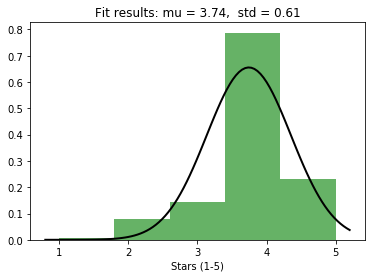

In [16]:
mu, std = norm.fit(dfMerged['stars'])
plt.hist(dfMerged['stars'], bins=5, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Stars (1-5)')
plt.show()



##### Review Count Distribution
Review count distribution is highly skewed. Mean is low because most of the restaurants have review count on lower side. Maximum review count is 8348 which is quite high but very few restaurants have that high review count.


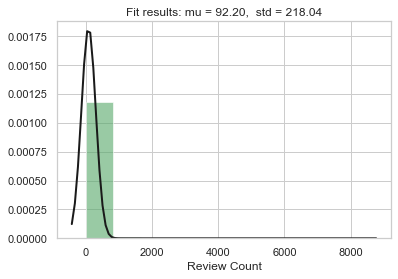

In [204]:
mu, std = norm.fit(dfBusiness['review_count'])
plt.hist(dfBusiness['review_count'], bins=10,density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Review Count')
plt.show()


Add column 'category' to categorize restaurants based on cuisines. There are total 17 types of cuisines considered in data analysis. 


In [17]:
dfMerged['category']=pd.Series()
dfMerged.loc[dfMerged.categories.str.contains('American'),'category'] = 'American'
dfMerged.loc[dfMerged.categories.str.contains('Japanese'),'category'] = 'Japanese'
dfMerged.loc[dfMerged.categories.str.contains('Mexican'),'category'] = 'Mexican'
dfMerged.loc[dfMerged.categories.str.contains('Italian'),'category'] = 'Italian'
dfMerged.loc[dfMerged.categories.str.contains('Iranian'),'category'] = 'Iranian'
dfMerged.loc[dfMerged.categories.str.contains('Polish'),'category'] = 'Polish'
dfMerged.loc[dfMerged.categories.str.contains('Hawaiian'),'category'] = 'Hawaiian'
dfMerged.loc[dfMerged.categories.str.contains('Taiwanese'),'category'] = 'Taiwanese'
dfMerged.loc[dfMerged.categories.str.contains('Vietnamese'),'category'] = 'Vietnamese'
dfMerged.loc[dfMerged.categories.str.contains('Mediterranean'),'category'] = 'Mediterranean'
dfMerged.loc[dfMerged.categories.str.contains('Thai'),'category'] = 'Thai'
dfMerged.loc[dfMerged.categories.str.contains('French'),'category'] = 'French'
dfMerged.loc[dfMerged.categories.str.contains('Greek'),'category'] = 'Greek'
dfMerged.loc[dfMerged.categories.str.contains('Indian'),'category'] = 'Indian'
dfMerged.loc[dfMerged.categories.str.contains('Korean'),'category'] = 'Korean'
dfMerged.loc[dfMerged.categories.str.contains('African'),'category'] = 'African'
dfMerged.loc[dfMerged.categories.str.contains('Spanish'),'category'] = 'Spanish'

In [18]:
dfMerged['category'].unique()

array(['Japanese', 'Mexican', 'Italian', nan, 'Iranian', 'Polish',
       'American', 'Thai', 'Korean', 'French', 'Mediterranean',
       'Hawaiian', 'Taiwanese', 'Vietnamese', 'Indian', 'Greek',
       'African', 'Spanish'], dtype=object)

In [208]:
dfMerged=dfMerged.dropna()
dfMerged.shape

(2034909, 18)

In [19]:
dfMerged.drop(columns=['categories'])

,business_id,name,address,city,state,latitude,longitude,stars,review_count,is_open,review_id,user_id,useful,funny,cool,text,category
0,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,F7POrJsNbhu493DSTMPXjw,nsS4oDfOsl20QdWc6XcOkw,1,0,0,"Husband was craving Chicken Teriyaki & gyoza, ...",Japanese
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,c-6aA9Bd7JxpmMroRoas9A,bK4Y_GZUoAUTXIrmeEUGYw,0,0,1,Went there Saturday noon they open at 12pm but...,Japanese
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,P_MV_lMQjLIO9R7M_KIuMg,sbbB6Y4yIZIInvt0LFYYew,1,0,0,Went to this restaurant on Saturday as I had a...,Japanese
3,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,dCLBdXP9tjjQG7EkHNeWzQ,hhQUVO2AqBdSeQcPo19Bsw,4,2,3,This place will always have a place in my stom...,Japanese
4,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,35.092564,-80.859132,4.0,170,1,GiBx0zRVxC1Bu-9R-MMF8w,XSz4svDvgOCRO92V_3ajWg,0,0,0,"Well first time I've really had ""authentic"" Ja...",Japanese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3425594,p1eUTUB_5hf1enoKYBV3DA,Ken Stewart's Tre Belle,1911 N Cleveland-Massillon Rd,Bath,OH,41.187547,-81.635791,3.5,39,1,DGwxHd3N8kJNs9GRnxp09A,ZO8h27XOn_XFKLLRRrLp0g,2,1,0,When I write a review on someplace that I have...,Italian
3425595,p1eUTUB_5hf1enoKYBV3DA,Ken Stewart's Tre Belle,1911 N Cleveland-Massillon Rd,Bath,OH,41.187547,-81.635791,3.5,39,1,xpfvecUdqyTug6ahkWQ9SQ,mwual7bROpwhZ3fu_GiPtQ,1,0,0,We stopped in at Tre Belle on a Tuesday evenin...,Italian
3425596,p1eUTUB_5hf1enoKYBV3DA,Ken Stewart's Tre Belle,1911 N Cleveland-Massillon Rd,Bath,OH,41.187547,-81.635791,3.5,39,1,5vt9FZre5dqksWzpj-8gCg,WKneD6tKr18q0ey0QbHBaA,1,0,0,I wasnt impressed. The place is beautiful and ...,Italian
3425597,p1eUTUB_5hf1enoKYBV3DA,Ken Stewart's Tre Belle,1911 N Cleveland-Massillon Rd,Bath,OH,41.187547,-81.635791,3.5,39,1,gLKSsgs4t2XPvfg6wOPuEQ,PxB2oZXO9N_4Zo2VIPUuGA,1,0,0,Last night some friends and I dined at this es...,Italian


Considering restaurants that are open 

In [209]:
dfMerged=dfMerged[dfMerged['is_open']==1]

##### Review Distribution
Exploring the distribution of review count based on city.
Restaurants in Las Vegas have most number of reviews followed by Phoenix and Scottsdale. Las Vegas is a tourist place and number of tourists visiting could possibly explain such high review count.

[833721232 140014081  83742956  36367557  34146056  29993804  29487216
  21077126  14815311  13891088]
Index(['Las Vegas', 'Phoenix', 'Scottsdale', 'Charlotte', 'Pittsburgh',
       'Henderson', 'Tempe', 'Gilbert', 'Mesa', 'Chandler'],
      dtype='object', name='city')


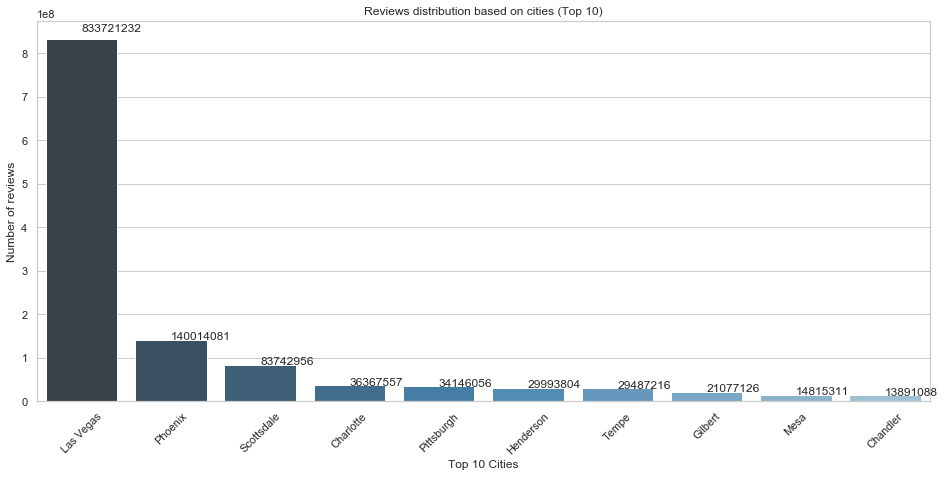

In [220]:
plt.figure(figsize=(16,7))
groupindex = dfMerged.groupby('city')['review_count'].sum().sort_values(ascending=False)[:10]
print(groupindex.values)
print(groupindex.index)
sns.barplot(groupindex.index, groupindex.values, palette="Blues_d")
plt.ylabel('Number of reviews')
plt.xlabel('Top 10 Cities')
plt.title('Reviews distribution based on cities (Top 10)')
plt.xticks(rotation=45)
for  i, v in enumerate(groupindex):
    plt.text(i, v*1.02, str(v))
    

Exploring the distribution of review count based on State. Again restaurants in Nevada have high number of review count. 

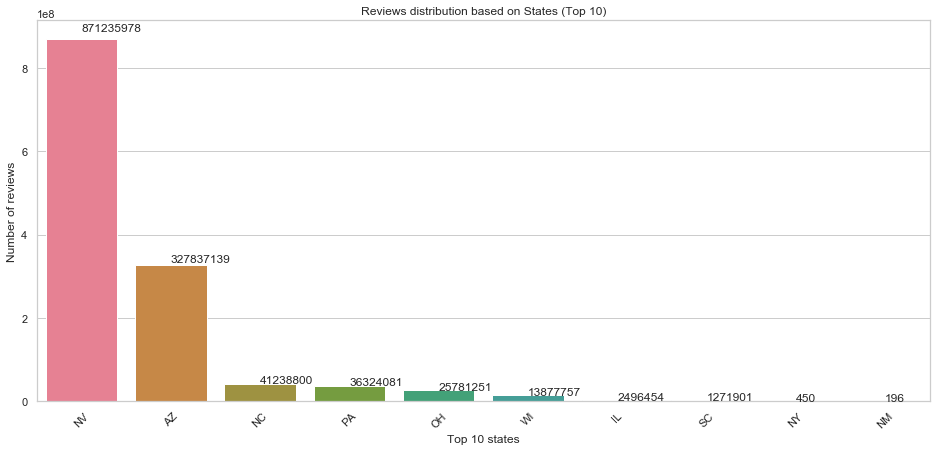

In [221]:
plt.figure(figsize=(16,7))
groupindex = dfMerged.groupby('state')['review_count'].sum().sort_values(ascending=False)[:10]
sns.barplot(groupindex.index, groupindex.values, palette='husl')
plt.ylabel('Number of reviews')
plt.xlabel('Top 10 states')
plt.title('Reviews distribution based on States (Top 10)')
plt.xticks(rotation=45)
for  i, v in enumerate(groupindex):
    plt.text(i, v*1.02, str(v))

Finding top rated restaurants 

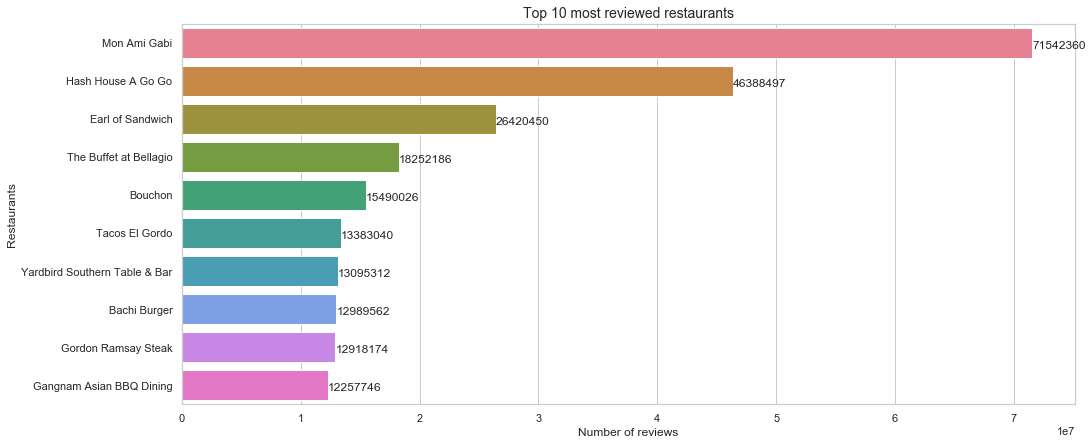

In [222]:
plt.figure(figsize=(16,7))
groupindex = dfMerged.groupby('name')['review_count'].sum().sort_values(ascending=False)[:10]
sns.barplot(x=groupindex.values, y=groupindex.index,palette='husl')
plt.xlabel('Number of reviews')
plt.ylabel('Restaurants')
plt.title('Top 10 most reviewed restaurants', fontsize=14)
for  i, v in enumerate(groupindex):
    plt.text(v, i+0.15, str(v))
plt.show()

Exploring the restaurants based on cuisine. There are significantly high number of restaurants serving American food as compared to any other type of cuisine.

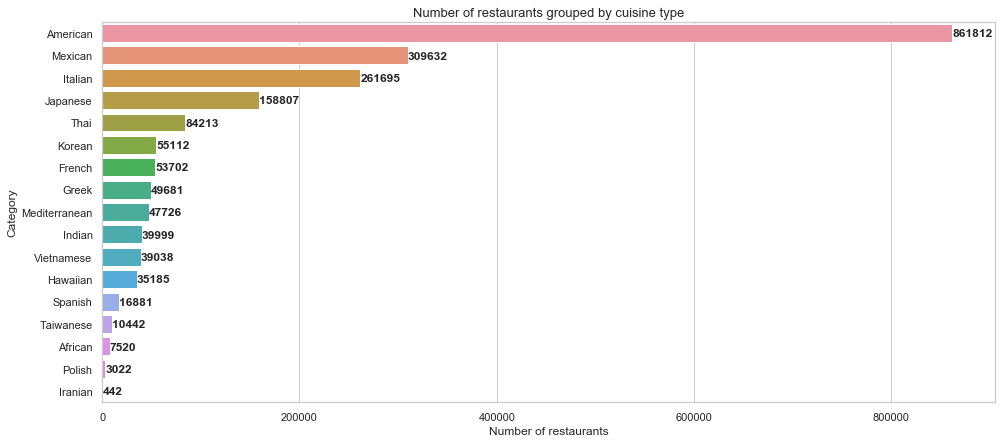

In [223]:
plt.figure(figsize=(16,7))
sns.set(style="whitegrid")
grouped = dfMerged.category.value_counts()
sns.countplot(y='category',data=dfMerged,order = grouped.index)
plt.xlabel('Number of restaurants', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Number of restaurants grouped by cuisine type', fontsize=13)
for  i, v in enumerate(dfMerged.category.value_counts()):
    plt.text(v, i+0.15, str(v), fontweight='bold', fontsize=12)


Top 10 cities with most restaurants.

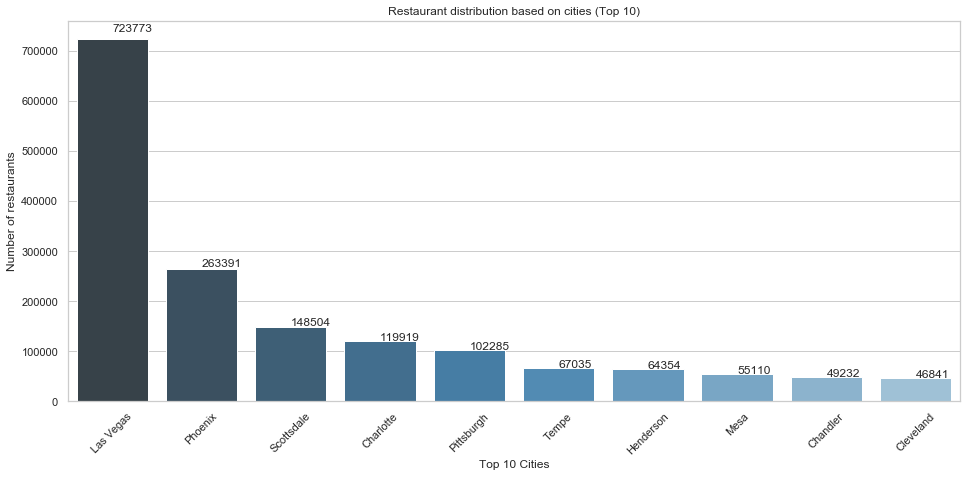

In [224]:
plt.figure(figsize=(16,7))
sns.set(style="whitegrid")
groupindex = dfMerged.city.value_counts()[:10]
sns.barplot(groupindex.index, groupindex.values, palette="Blues_d")
plt.ylabel('Number of restaurants')
plt.xlabel('Top 10 Cities')
plt.title('Restaurant distribution based on cities (Top 10)')
plt.xticks(rotation=45)
for  i, v in enumerate(groupindex):
    plt.text(i, v*1.02, str(v))

Top states based on number of restaurants 

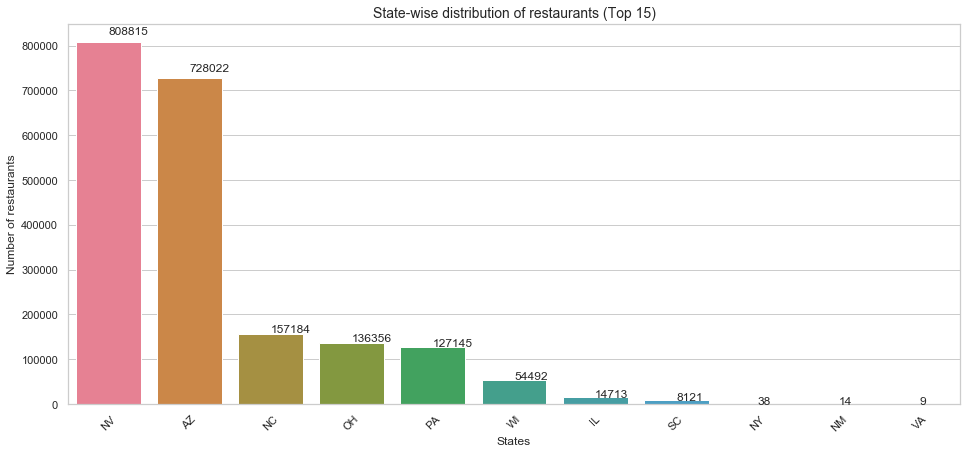

In [225]:
plt.figure(figsize=(16,7))
sns.set(style="whitegrid")
groupindex = dfMerged.state.value_counts()[:15]
sns.barplot(groupindex.index, groupindex.values, palette='husl')
plt.ylabel('Number of restaurants')
plt.xlabel('States')
plt.title('State-wise distribution of restaurants (Top 15)', fontsize=14)
plt.xticks(rotation=45)
for  i, v in enumerate(groupindex):
    plt.text(i, v*1.02, str(v))

### Statistical Testing

###### Test 1
Test if the distribution of review_counts in NV and AZ follow the same distribution. \
Significance level = 5% \
Conslusion:- Distribution of review_count of NV and AZ doesnot follow the same distribution


In [213]:
nv = dfBusiness[dfBusiness['state']=='NV']['review_count']
az = dfBusiness[dfBusiness['state']=='AZ']['review_count']
ks_2samp(nv.tolist(),az.tolist())
print("Statistic:- \t", round(stats,4), "\nP-value:-\t", pvalue)

Statistic:- 	 0.0133 
P-value:-	 0.0


###### Test 2
Test if event (review count<20 or not)  and event (if business is open) are independent \
Conslusion:- Above two events are dependent

In [214]:
a,b = dfBusiness[dfBusiness['review_count'] <= 20].groupby(dfBusiness['is_open']).size().tolist()
c, d = dfBusiness[dfBusiness['review_count'] > 20].groupby(dfBusiness['is_open']).size().tolist()
print(a,b,c,d)
chi2_contingency([[a, b], [c, d]])

6157 8513 4708 16515


(1607.9658528805332, 0.0, 1, array([[ 4440.68620622, 10229.31379378],
        [ 6424.31379378, 14798.68620622]]))

###### Test 3
Test if event (stars> 3 or not)  and event (if business is open) are independent \
Conslusion:- Above two events are dependent

In [215]:
a,b = dfBusiness[dfBusiness['stars'] <= 3.0].groupby(dfBusiness['is_open']).size().tolist()
c, d = dfBusiness[dfBusiness['stars'] > 3.0].groupby(dfBusiness['is_open']).size().tolist()
print(a,b,c,d)
chi2_contingency([[a, b], [c, d]])

4165 9147 6700 15881


(10.292730312392516,
 0.0013355532700178834,
 1,
 array([[ 4029.61245925,  9282.38754075],
        [ 6835.38754075, 15745.61245925]]))

###### Test 4
Test if mean review_count of business in NV equals mean review_count in AZ \
Conclusion:- Population mean of review count of Nevada and Arizona is different.

In [218]:
nv = dfBusiness[dfBusiness['state']=='NV']['review_count'].mean()
az = dfBusiness[dfBusiness['state']=='AZ']['review_count'].mean()
stats, pvalue=ttest_ind(dfBusiness[dfBusiness['state']=='NV']['review_count'].tolist(), dfBusiness[dfBusiness['state']=='AZ']['review_count'].tolist(), equal_var = False)
print("Statistic:- \t", round(stats,4), "\nP-value:-\t", round(pvalue,4))


Statistic:- 	 15.6058 
P-value:-	 0.0
